In [213]:
import pandas as pd
import yfinance as yf
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr

# make the necessary imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.vecm import coint_johansen

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
yf.pdr_override()

In [298]:
tickers =  ['COP','XOM','CVX','WTI','XLE','SPY']

start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022, 11, 1)

start_train='2012-01-01'
start_test='2020-01-01'
end_test='2022-11-01'
data = pdr.get_data_yahoo(tickers, start_train, end_test)['Adj Close']


[*********************100%***********************]  6 of 6 completed


In [299]:
descriptive_statistics=data.describe()
descriptive_statistics.to_latex(float_format="%.2f")

C:\Users\ems\AppData\Local\Temp\ipykernel_13184\2196733929.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  descriptive_statistics.to_latex(float_format="%.2f")


'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &     COP &     CVX &     SPY &     WTI &     XLE &     XOM \\\\\n\\midrule\ncount & 2726.00 & 2726.00 & 2726.00 & 2726.00 & 2726.00 & 2726.00 \\\\\nmean  &   50.90 &   89.64 &  240.88 &    6.97 &   53.42 &   60.30 \\\\\nstd   &   16.83 &   22.21 &   97.94 &    5.34 &   10.43 &   11.27 \\\\\nmin   &   20.34 &   47.61 &  104.07 &    1.09 &   20.81 &   26.77 \\\\\n25\\%   &   39.57 &   76.48 &  169.18 &    2.92 &   48.77 &   56.78 \\\\\n50\\%   &   48.58 &   83.99 &  219.97 &    4.64 &   52.76 &   60.41 \\\\\n75\\%   &   56.26 &   98.67 &  294.31 &   10.87 &   58.45 &   64.15 \\\\\nmax   &  126.69 &  179.51 &  472.24 &   23.59 &   90.27 &  109.93 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [300]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    cvalue = adfuller(X)[0]
    print('Critical-value of ' + X.name + '=' + str("{:.3f}".format(cvalue)))

In [301]:
difference = data.diff(axis=0)
df_new=pd.DataFrame(difference[1:])
df_new

,COP,CVX,SPY,WTI,XLE,XOM
Date,,,,,,
2012-01-04,-0.183079,-0.121574,0.163246,-0.527491,0.102383,0.012753
2012-01-05,-0.308601,-0.690895,0.277527,-0.202204,-0.232090,-0.166019
2012-01-06,-0.298138,-0.505379,-0.269341,-0.404406,-0.286736,-0.408672
2012-01-09,0.146458,0.754875,0.253029,0.123075,0.232101,0.242653
2012-01-10,0.177826,-0.275078,0.906067,0.369247,0.430099,0.140480
...,...,...,...,...,...,...
2022-10-25,-1.195427,1.786179,6.050018,0.170000,0.090004,-0.714249
2022-10-26,2.619987,2.143417,-2.900024,0.110000,1.190002,1.249939
2022-10-27,0.069733,0.803787,-2.039978,-0.210000,0.320000,0.406731


In [302]:
stationarity_test(df_new['WTI'])
stationarity_test(df_new['XOM'])
stationarity_test(df_new['CVX'])
stationarity_test(df_new['COP'])
stationarity_test(df_new['XLE'])
stationarity_test(df_new['SPY'])

Critical-value of WTI=-14.009
Critical-value of XOM=-9.472
Critical-value of CVX=-10.642
Critical-value of COP=-10.571
Critical-value of XLE=-10.248
Critical-value of SPY=-10.954


In [303]:
train_close, test_close = train_test_split(data, test_size=0.2625, shuffle=False)

In [304]:
#Define function to find cointegrated pairs from chosen tickers
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [305]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
pvalues, pairs = find_cointegrated_pairs(train_close[['COP','CVX','WTI','XOM']])
#fig, ax = plt.subplots(figsize=(10,7))
#sns.heatmap(pvalues, xticklabels = train_close[['COP','CVX','WTI','XOM']].columns,
                #yticklabels = df[['COP','CVX','WTI','XLE','XOM']].columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                #mask = (pvalues >= 0.99))
#plt.tight_layout()
#plt.savefig('co_matrix', dpi=300) 

In [306]:
#Estimation of the Johansen test
keys=train_close.keys()
for i in [0,1,5]:
    jh_results = coint_johansen(train_close.iloc[:,[i,3]], det_order=0, k_ar_diff=1)
    print(keys[i])
    print(jh_results.lr1)# dim = (n,) Trace statistic
#here we compare the maximum eigenvalue statistics with the critical values of this and find the most co-integrating pair.

COP
[8.32862794 3.53120098]
CVX
[7.64305826 3.39130819]
XOM
[18.76859652  4.42158609]


In [307]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1,res.eig],
                          index=['max_eig_stat',"trace_stat","Eigen_values"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')


In [308]:
joh_output(jh_results)

   max_eig_stat  trace_stat  Eigen_values
0     14.347010   18.768597      0.007119
1      4.421586    4.421586      0.002200 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



In [309]:
v1 = jh_results.evec[:, 0]
v2 = jh_results.evec[:, 1]
if jh_results.eig[0]>jh_results.eig[1]:
    beta_co=v1[1]/v1[0] # Normalizing the beta coefficient, depending on which eigenvalues are the largest. 
else:
    beta_co=v2[1]/v2[0]
print(beta_co)        

0.09404974599882765


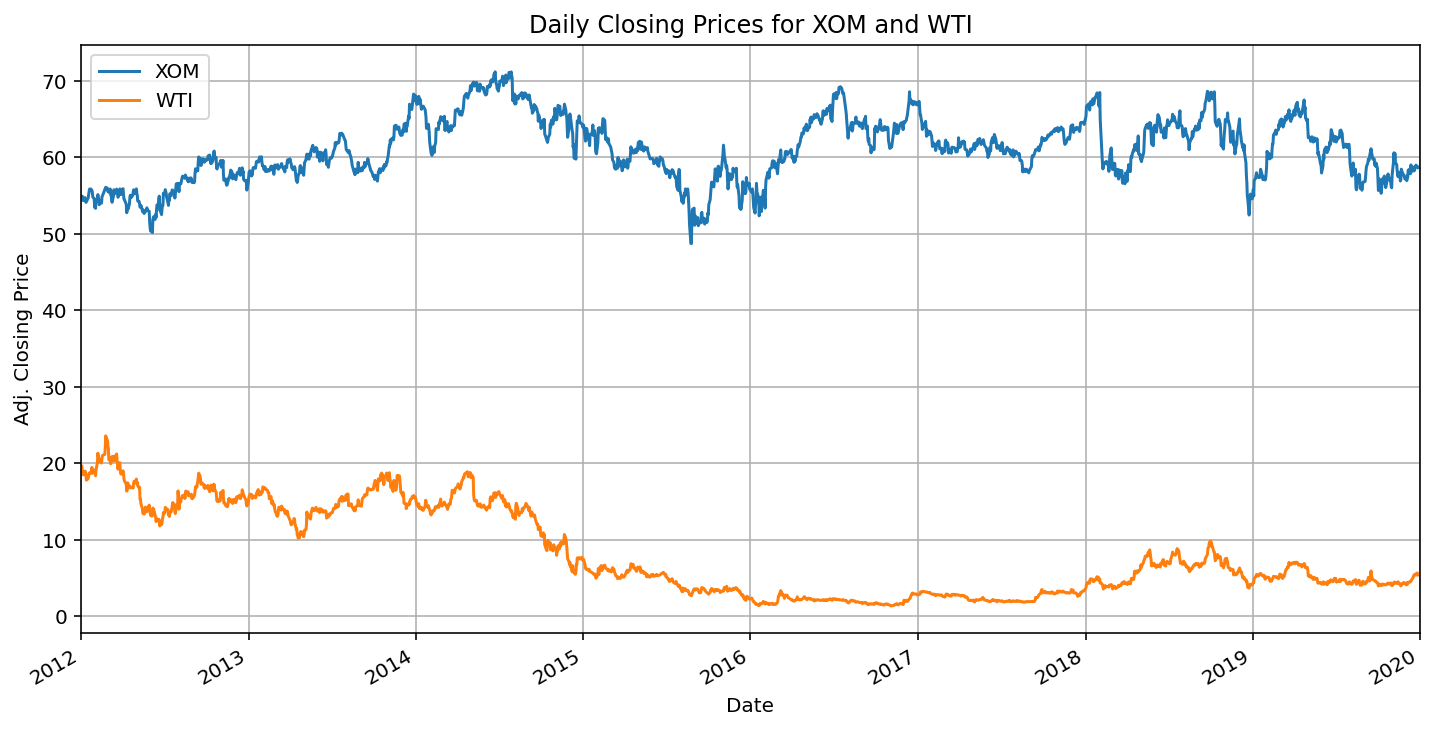

In [310]:
# final pair to test strategy (To obtain results from other promising assets, this has to be changed here)
asset1 = 'XOM'
asset2 = 'WTI'

# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Adj. Closing Price")
ax.set_xlim(start_train,start_test)
ax.legend(['XOM','WTI']) #Change ticker name here as well
ax.grid(True);

In [311]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

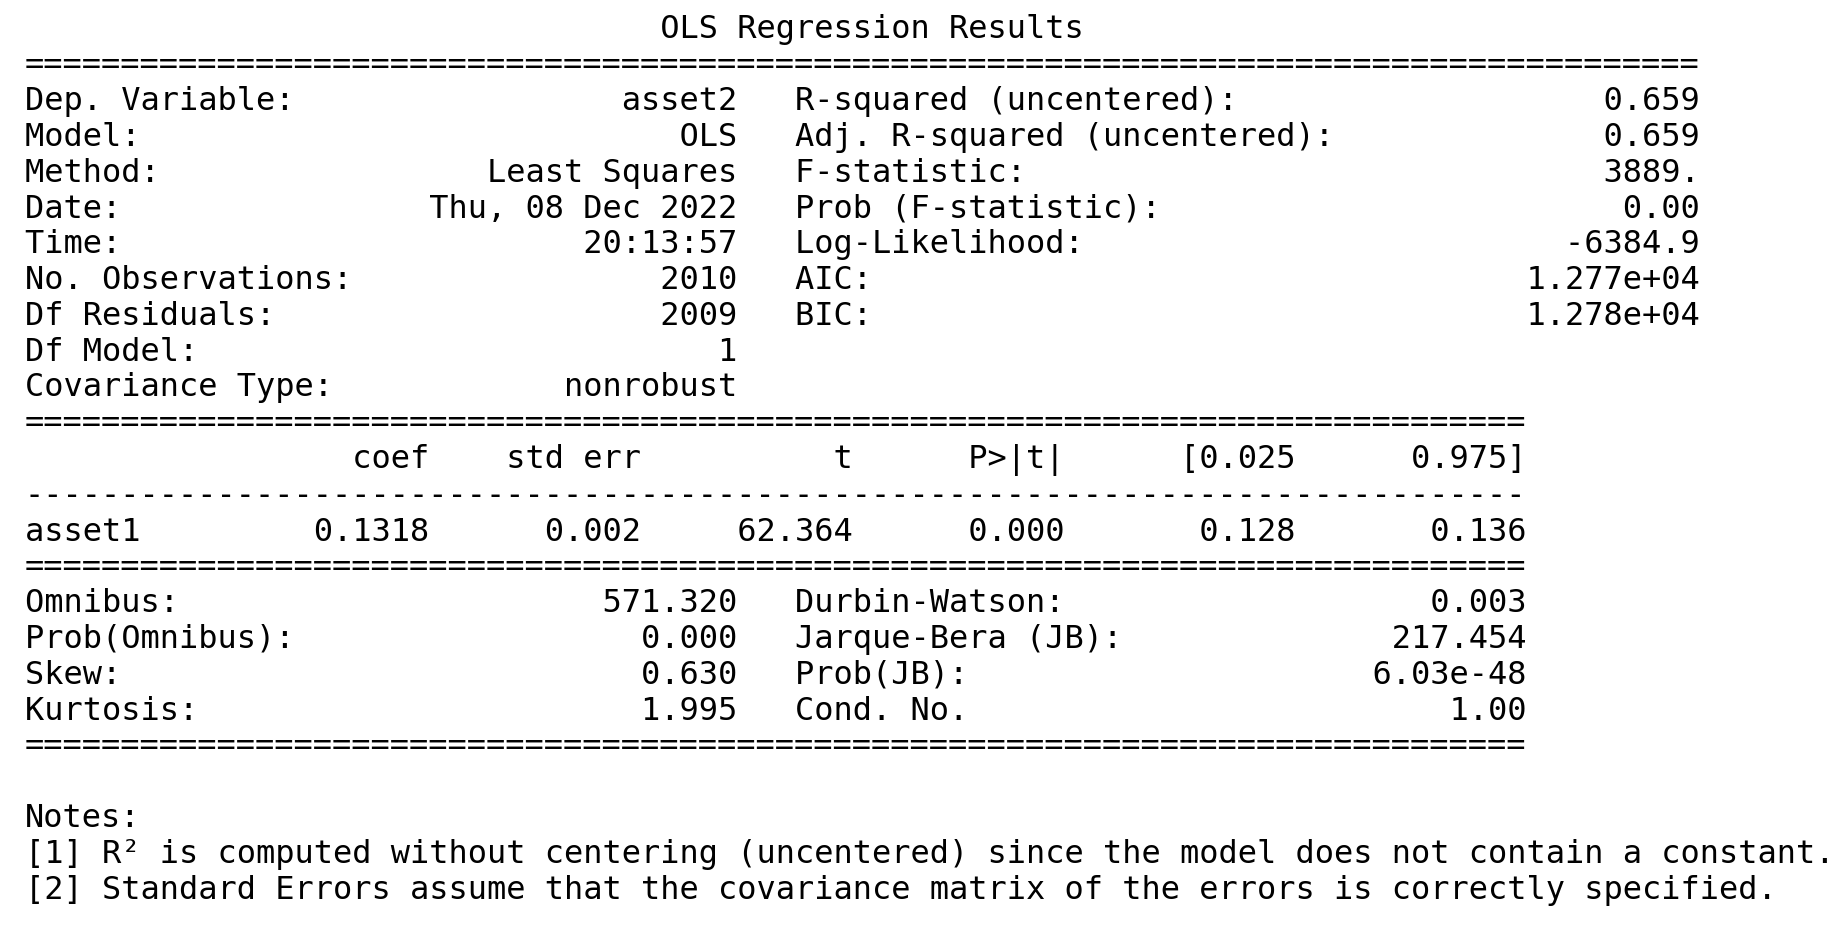

In [312]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

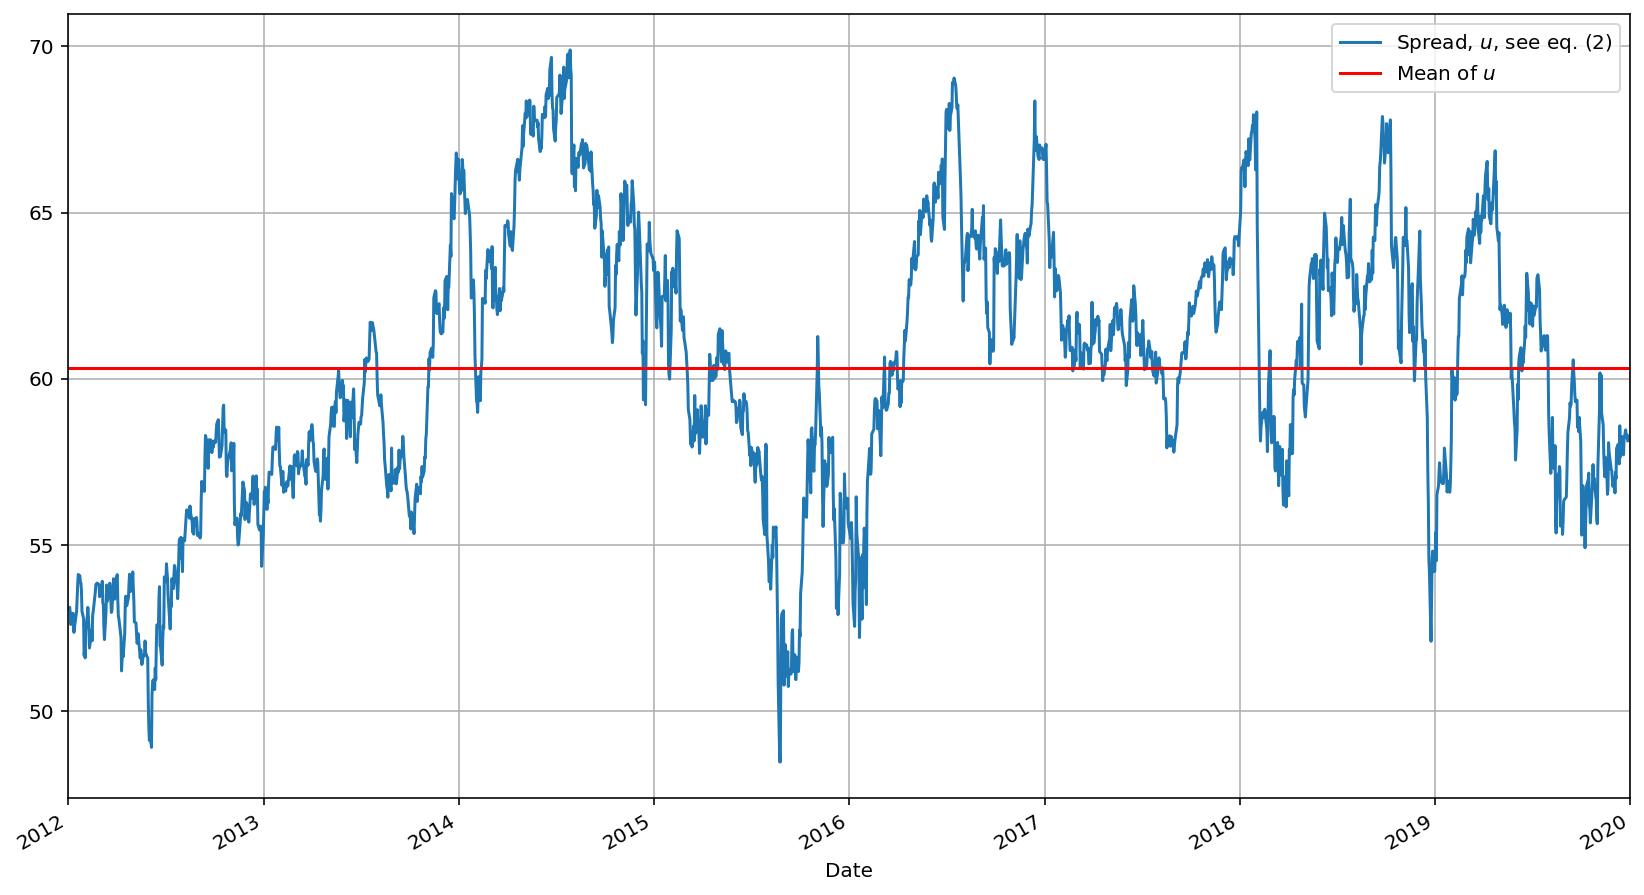

In [313]:
# calculate spread
spread = train.asset1 - beta_co * train.asset2
mean=np.mean(spread)
# Plot the spread
ax = spread.plot(figsize=(14, 8))
ax.axhline(y = np.mean(spread), color = 'r', linestyle = '-')
ax.set_xlim(start_train,start_test)
ax.legend(['Spread, $u$, see eq. (2)','Mean of $u$'])
ax.grid(True);
plt.savefig('FINAL spread_'+asset2+asset1, dpi=300, orientation='landscape')

In [314]:
np.mean(spread)

60.316929825420765

In [315]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('P Value = ', adf[1])

P Value =  0.004140647332092279


In [316]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1]
signals['asset2'] = test_close[asset2]
ratios = signals.asset1/signals.asset2
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + 1.2*np.std(signals['z'])
signals['revert upper limit']= np.mean(signals['z']) + 0.5*np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - 1.2*np.std(signals['z'])
signals['revert lower limit']= np.mean(signals['z']) - 0.5*np.std(signals['z'])


In [317]:
# create signal - if z-score is greater than upper limit(short) or between upper and revert upper limit (hold) else long
signals['signals1'] = pd.Series(dtype='int')
n = signals.shape[0]
for i in range(n):
    if signals['z'][i]>signals['z upper limit'][i] and signals['z'][i] > signals['revert upper limit'][i]:
        signals['signals1'][i]=-1 
    elif signals['z'][i] < signals['z upper limit'][i] and signals['z'][i] > signals['revert upper limit'][i]:
        signals['signals1'][i]=0
    elif signals['z'][i] < signals['z upper limit'][i] and signals['z'][i] < signals['revert upper limit'][i]:                                                     
        signals['signals1'][i]=1
    elif signals['z'][i] > signals['z lower limit'][i] and signals['z'][i] > signals['revert lower limit'][i]:
        signals['signals1'][i]=1                 
    elif signals['z'][i] > signals['z lower limit'][i] and signals['z'][i] < signals['revert lower limit'][i]:
        signals['signals1'][i]=0
    elif signals['z'][i] < signals['z lower limit'][i] and signals['z'][i] < signals['revert lower limit'][i]:                                                     
        signals['signals1'][i]=-1 
    else:
        signals['signals1'][i]=0

In [318]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

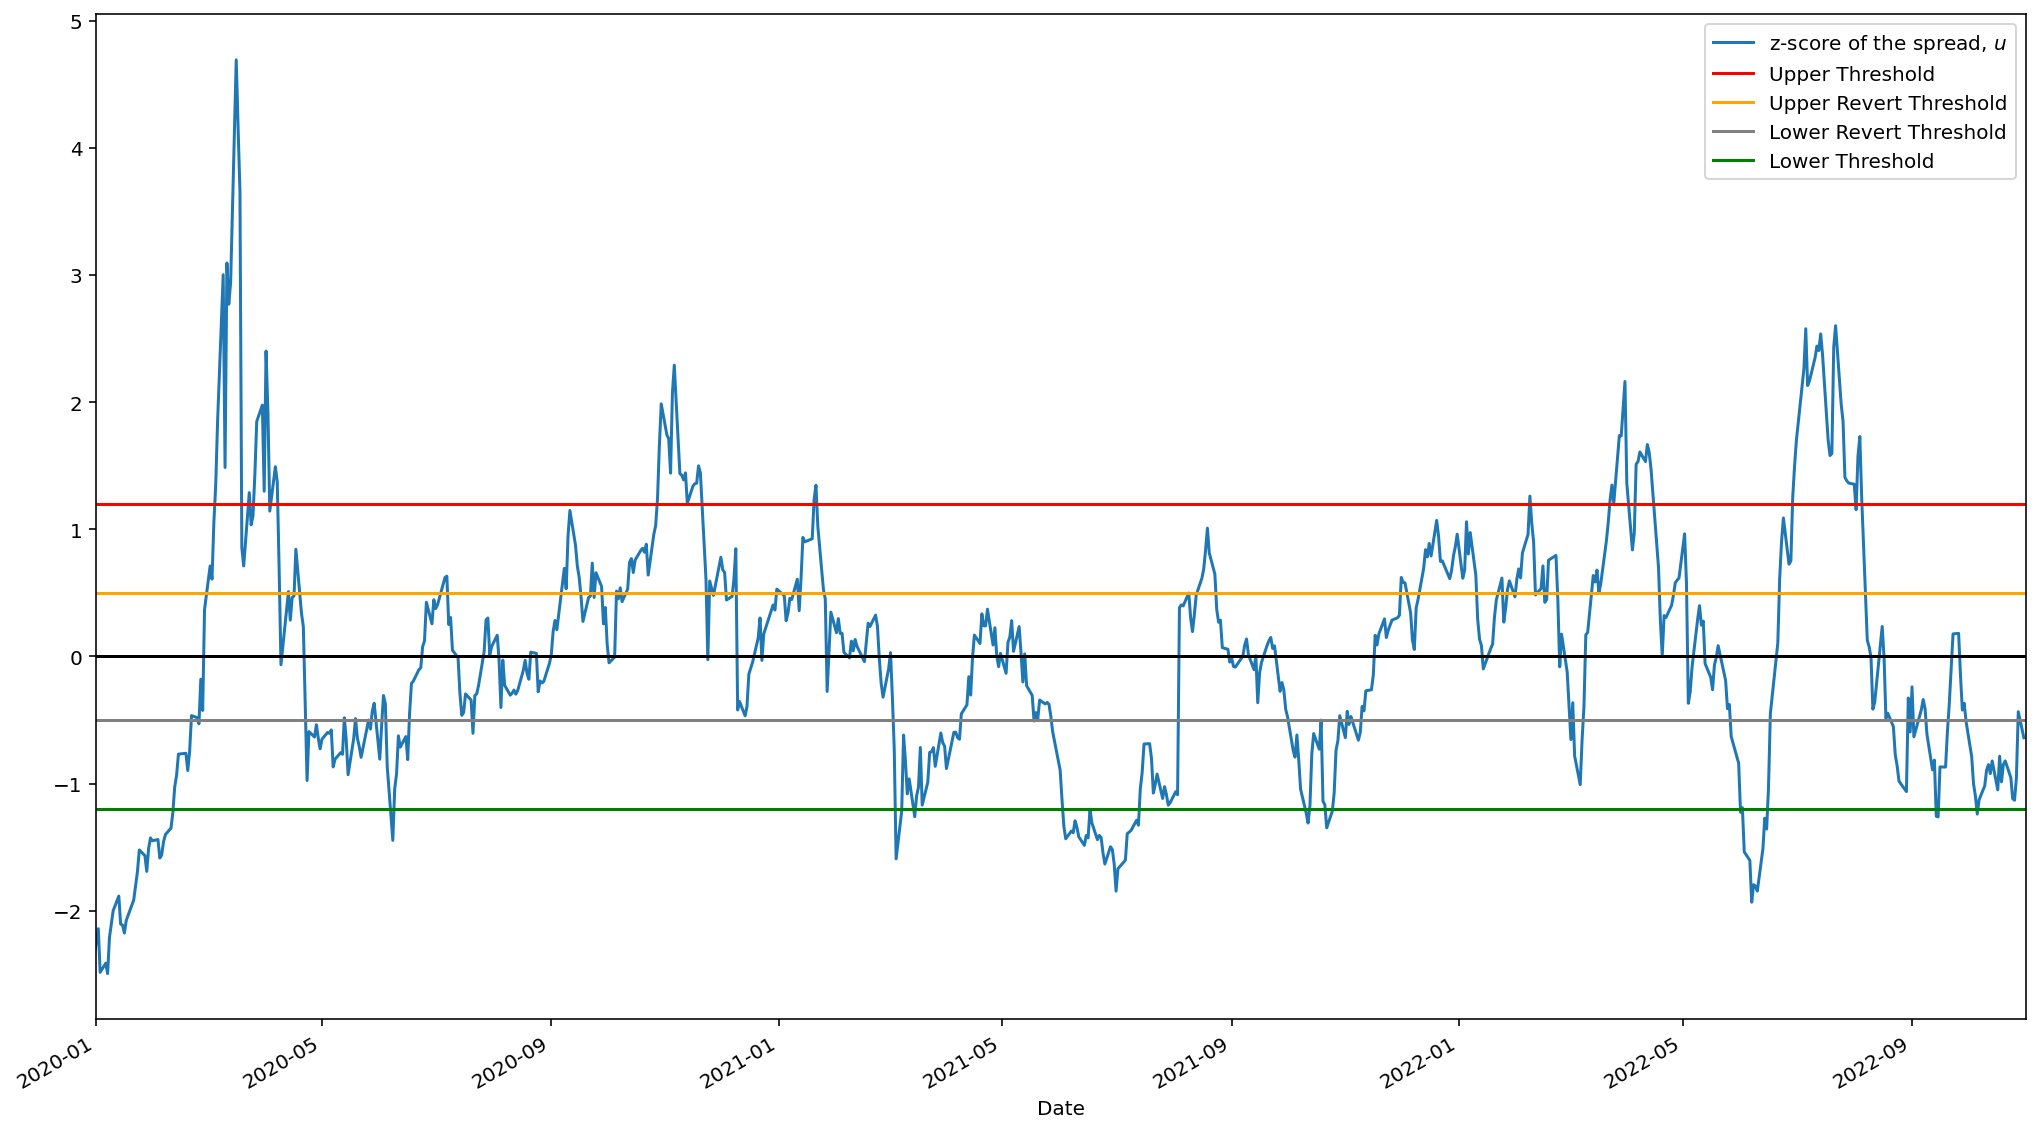

In [319]:
# visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z-score of the spread, $u$", figsize=(14,8))
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['revert upper limit'].mean(), color="orange", label="Upper Revert Threshold")
plt.axhline(signals['revert lower limit'].mean(), color="grey", label="Lower Revert Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.xlim(start_test, end_test)
plt.savefig('FINAL zscore'+asset2+asset1, dpi=300)

In [320]:
signals['positions1'].tail()

Date
2022-10-25    0.0
2022-10-26    0.0
2022-10-27    0.0
2022-10-28    0.0
2022-10-31    0.0
Name: positions1, dtype: float64

In [321]:
ratios=data[asset1]-beta_co*data[asset2]
std = ratios.rolling(window=30, center=False).std()
ma_5=ratios.rolling(window=5, center=False).mean()
ma_30=ratios.rolling(window=30, center=False).mean()
zscore = (ma_5 - ma_30)/std

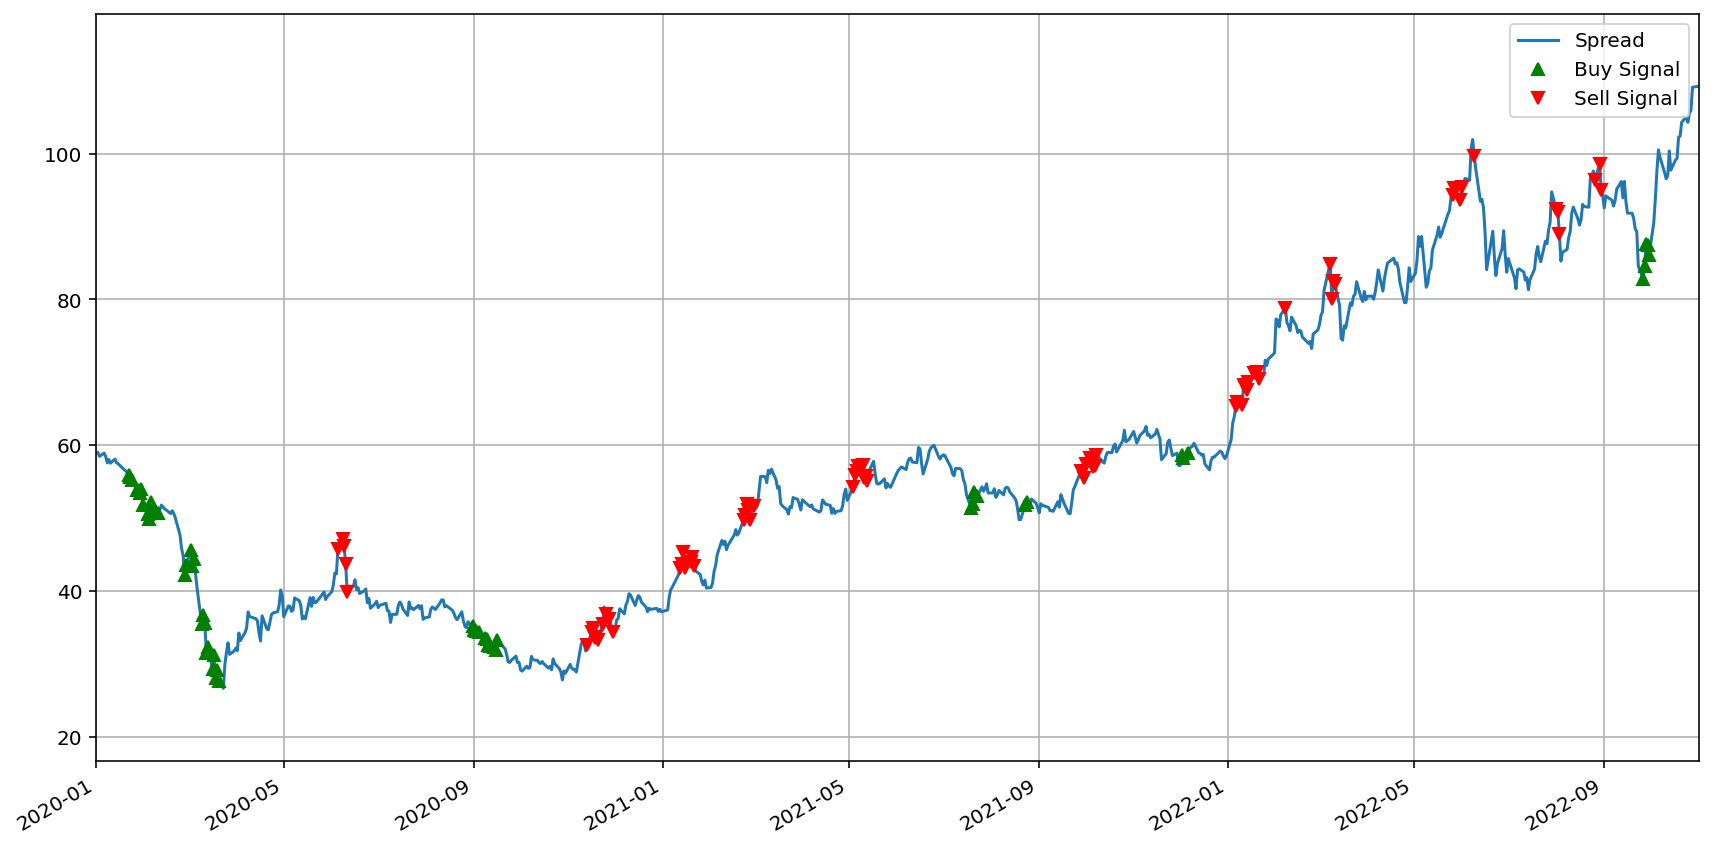

In [322]:
plt.figure(figsize=(12,6))

ratios[start_test:].plot()
buy = ratios.copy()
sell = ratios.copy()
#These are just set to -100 for visual reasons, such that it does not enter the graph when nothing should be done. 
buy[zscore>-1.5] = -100
buy[zscore>-0.5] = -100
sell[zscore<1.5] = -100
sell[zscore<0.5] = -100
buy[start_test:].plot(color='g', linestyle='None', marker='^')
sell[start_test:].plot(color='r', linestyle='None', marker='v')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min()-10, ratios.max()+10))
plt.xlim(start_test,end_test)
plt.xlabel(None)
plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.grid(True)
plt.tight_layout()
plt.savefig('FINAL Strategy'+asset2+asset1, dpi=300)

# Portfolio Profit and Loss Calculation

In [323]:
# initial capital to calculate the actual pnl
initial_capital = 5000
# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'][start_test:])
positions2 = initial_capital// max(signals['asset2'][start_test:])

In [324]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1'][start_test:] 
portfolio['holdings1'] = signals['positions1'][start_test:].cumsum() * signals['asset1'][start_test:]  * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'][start_test:] * signals['asset1'][start_test:]  * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1'][start_test:] 

In [325]:
signals['trade']=pd.Series(dtype='int')
for i in range(len(signals['positions2'][start_test:])):
    if signals['positions2'][i]!=signals['positions2'][i+1]:
        signals['trade'][i]=1
    else:
        signals['trade'][i]=0

In [326]:
signals['trade'].dropna()
signals['trade'].sum()

123.0

In [327]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2'][start_test:] 
portfolio['holdings2'] = signals['positions2'][start_test:] .cumsum() * signals['asset2'][start_test:]  * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'][start_test:] * signals['asset2'][start_test:]  * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2'][start_test:] 

In [328]:
portfolio['TC']=signals['trade']*10
# total pnl and z-score
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']-portfolio['TC']
portfolio['total return'] = portfolio['return1'] + portfolio['return2']
portfolio = portfolio.dropna()

In [329]:
import ffn
prices=ffn.get('XLE,SPY,WTI,XOM',start=start_test, end=end_test)
xle=prices['xle'].rebase(10000)
spy=prices['spy'].rebase(10000)
xom=prices['xom'].rebase(5000)
wti=prices['wti'].rebase(5000)
bandh=wti+xom

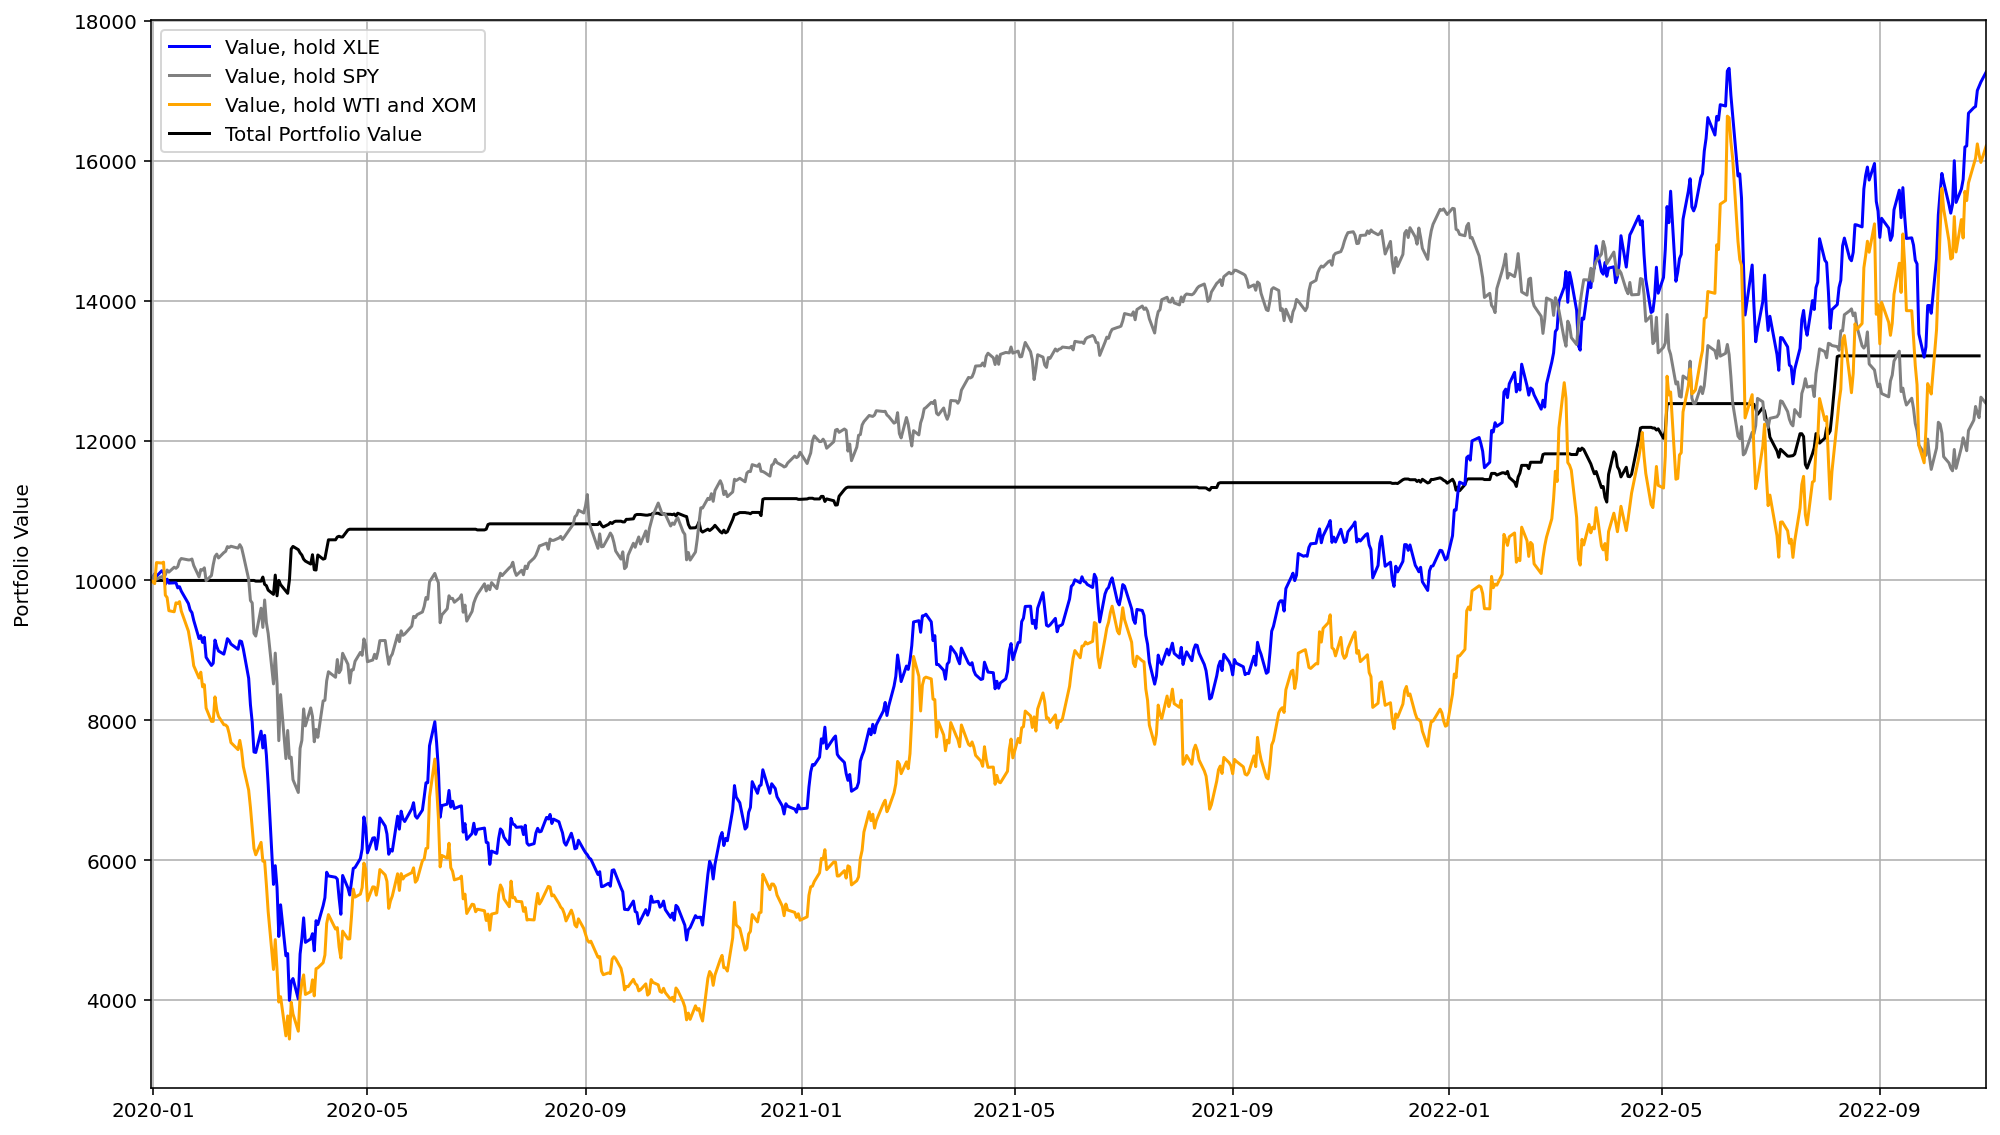

In [331]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,8),)
ax = fig.add_subplot(111)

l1, = ax.plot(portfolio['total asset'], c='black')
l2, = ax.plot(xle,c='blue')
l3, = ax.plot(spy,c='grey')
l5, = ax.plot(bandh,c='orange')

ax.set_ylabel('Portfolio Value')
ax.yaxis.labelpad=20
ax.xaxis.labelpad=10
ax.margins(x=0)
plt.legend([l2,l3,l5,l1],['Value, hold XLE',
                      'Value, hold SPY', 'Value, hold WTI and XOM',
                      'Total Portfolio Value'],loc='upper left')
plt.grid(True)
plt.tight_layout();
plt.savefig('FINAL performance'+asset2+asset1, dpi=300)

In [257]:
#Calculate turnover:

def return_change(asset_t,asset_t1):
    return print(((asset_t1-asset_t)/asset_t1)*100)
def return_change_fee(asset_t,asset_t1,fee):
    return print(((asset_t1-asset_t-fee)/asset_t1)*100)


In [264]:
pair_trading_return=return_change(portfolio.iloc[1,13],portfolio.iloc[-1,13])
hold_asset1_return=return_change(spy[1],spy[-1])
hold_asset1_return=return_change(xle[1],xle[-1])
hold_asset1_return=return_change(bandh[1],bandh[-1])


24.309068117854867
19.443556149350204
41.579297383626304
38.60004020012907
